# Emotional Arcs für Soundtracks

**Ziel:** Betrachtung von Sentiments bzw. Emotionen im Verlauf eines Filmes auf Basis der Filmmusik analog zu textbasierten Ansätzen

Referenzpaper:
* The emotional arcs of stories are dominated by six basic shapes (2016)
* A Survey on Sentiment and Emotion Analysis for Computational Literary Studies. | 4.5.1 Emotion Flow Analysis (2019)

## Imports

Spotify Related

In [3]:
from spotify_client import *

In [4]:
client_id = "85434f2d38ba4509924f3940ec3b40ed"
client_secret = "3bb1e3237c334e95b1db5244740d2fc0"

In [5]:
spotify = SpotifyAPI(client_id, client_secret)

In [6]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [7]:
SPOTIPY_CLIENT_ID='85434f2d38ba4509924f3940ec3b40ed'
SPOTIPY_CLIENT_SECRET='3bb1e3237c334e95b1db5244740d2fc0'

In [8]:
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(SPOTIPY_CLIENT_ID,SPOTIPY_CLIENT_SECRET))

IMDB

In [9]:
import imdb

In [10]:
ia = imdb.IMDb()

Data Processing

In [11]:
import json
import requests
import re
import sys

In [12]:
import pandas as pd
import numpy as np

Visualisierungen

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# Using plotly.express
import plotly.express as px

## Schritt 1: Korpus erstellen

Zielformat pro Soundtrack:

`{albumid: SpotifyAlbumID, albumtitel: Albumtitel, filmtitel: Filmtitel (nach Regex), valence: [Valence Scores], energy: [Energy Scores], genres: [IMDB genres]}` 

### Soundtracks Retrieval

Client initialisieren für Abfragen etc.

Methode für die Suche

In [15]:
def search(query=None, search_type='artist', limit=20, offset=0):
        if isinstance(query, dict):
            query = " ".join([f"{k}:{v}" for k,v in query.items()])
            print(query)
        query_params = urlencode({"q": query, "type": search_type.lower(), "limit": limit, "offset": offset})
        print(query_params)
        return spotify.base_search(query_params)

Retrieval von 1000 Soundtracks | Level: Albuminformationen

Hinweis: Limit pro Suchanfrage sind 50 Alben; daher 20 * 50 Alben mit Offset abgerufen.

In [16]:
result_lists=[]
for i in range (0,951,50):
    results = search({"album":"Original Motion Picture Soundtrack"},search_type="album", limit=50, offset=i)
    result_lists.append(results)

album:Original Motion Picture Soundtrack
q=album%3AOriginal+Motion+Picture+Soundtrack&type=album&limit=50&offset=0
album:Original Motion Picture Soundtrack
q=album%3AOriginal+Motion+Picture+Soundtrack&type=album&limit=50&offset=50
album:Original Motion Picture Soundtrack
q=album%3AOriginal+Motion+Picture+Soundtrack&type=album&limit=50&offset=100
album:Original Motion Picture Soundtrack
q=album%3AOriginal+Motion+Picture+Soundtrack&type=album&limit=50&offset=150
album:Original Motion Picture Soundtrack
q=album%3AOriginal+Motion+Picture+Soundtrack&type=album&limit=50&offset=200
album:Original Motion Picture Soundtrack
q=album%3AOriginal+Motion+Picture+Soundtrack&type=album&limit=50&offset=250
album:Original Motion Picture Soundtrack
q=album%3AOriginal+Motion+Picture+Soundtrack&type=album&limit=50&offset=300
album:Original Motion Picture Soundtrack
q=album%3AOriginal+Motion+Picture+Soundtrack&type=album&limit=50&offset=350
album:Original Motion Picture Soundtrack
q=album%3AOriginal+Motion+

In [17]:
len(result_lists)

20

**Albuminformationen für ein Beispielalbum**

In [18]:
result_lists[0]['albums']['items'][0].keys()

dict_keys(['album_type', 'artists', 'available_markets', 'external_urls', 'href', 'id', 'images', 'name', 'release_date', 'release_date_precision', 'total_tracks', 'type', 'uri'])

In [19]:
result_lists[0]['albums']['items'][0]['id']

'4M07HWIlZr7zoXoxDHR5mz'

In [20]:
result_lists[0]['albums']['items'][0]['name']

'Frozen 2 (Original Motion Picture Soundtrack/Deluxe Edition)'

### Transform to DataFrame [for better Processing]

In [21]:
df = pd.DataFrame(result_lists[0]['albums']['items'])

In [22]:
for i in range(1,20):
    df = df.append(pd.DataFrame(result_lists[i]['albums']['items']),ignore_index=True)

In [23]:
df.describe()

,total_tracks
count,1000.000000
mean,17.427000
std,9.668824
min,1.000000
25%,11.000000
50%,16.000000
75%,22.000000
max,88.000000


### Methodenblock für die Anreicherung der Albuminformationen

Anmerkung: Methode zur Aufbereitung der Titel für IMDB Retrieval erforderlich, da ohne Aufbereitung getestet, hat nicht funktioniert.

In [24]:
def regex_reduce_title(row):
    title = row['name']
    title = re.sub('(\([a-zA-Z /\[\].&""]+\))', '', title)
    title = re.sub('(Original Motion Picture Soundtrack)', '', title)
    title = re.sub("(\[[a-zA-Z ']+\])",'',title)
    title = re.sub('\[\]','',title)
    title = re.sub('-','',title)
    title = re.sub('/','',title)   
    return title

In [25]:
def create_valence_list(row,spotipy_client):
    albumid = row['id']
    valence_list = []
    for item in spotipy_client.album_tracks(albumid)['items']:
        trackid = item['id']
        try:
            valence_list.append(spotipy_client.audio_features(item['id'])[0]['valence'])
        except TypeError:
            continue
    return valence_list

In [26]:
def create_energy_list(row,spotipy_client):
    albumid = row['id']
    energy_list = []
    for item in spotipy_client.album_tracks(albumid)['items']:
        trackid = item['id']
        try:
            energy_list.append(spotipy_client.audio_features(item['id'])[0]['energy'])
        except TypeError:
            continue
    return energy_list

In [27]:
def add_imdb_genres(row,imdb_client):
    title = row['reduced_title']
    movie = imdb_client.search_movie(title, results=1)
    try:
        movie_id = movie[0].movieID
        genres = imdb_client.get_movie_main(movie_id)['data']['genres']
    except IndexError:
        genres = "None"
    return genres

### Anreicherung des DataFrames

In [36]:
df['reduced_title'] = df.apply(lambda row: regex_reduce_title(row), axis=1)

In [38]:
df['valence_list'] = df.apply(lambda row: create_valence_list(row,sp), axis=1)

In [42]:
df['energy_list'] = df.apply(lambda row: create_energy_list(row,sp), axis=1)

In [60]:
df['genres'] = df.apply(lambda row: add_imdb_genres(row,ia), axis=1)

In [64]:
df.to_csv('soundtracksData.csv', index = False)

In [116]:
df = pd.read_csv('soundtracksData.csv')

In [117]:
df.head()

,album_type,artists,available_markets,external_urls,href,id,images,name,release_date,release_date_precision,total_tracks,type,uri,reduced_title,valence_list,energy_list,genres
0,album,[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",{'spotify': 'https://open.spotify.com/album/4M...,https://api.spotify.com/v1/albums/4M07HWIlZr7z...,4M07HWIlZr7zoXoxDHR5mz,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Frozen 2 (Original Motion Picture Soundtrack/D...,2019-11-15,day,46,album,spotify:album:4M07HWIlZr7zoXoxDHR5mz,Frozen 2,"[0.195, 0.299, 0.274, 0.434, 0.311, 0.293, 0.1...","[0.204, 0.543, 0.405, 0.326, 0.0885, 0.478, 0....","['Animation', 'Adventure', 'Comedy', 'Family',..."
1,compilation,[{'external_urls': {'spotify': 'https://open.s...,"['AE', 'AR', 'AU', 'BH', 'BO', 'BR', 'CA', 'CL...",{'spotify': 'https://open.spotify.com/album/6p...,https://api.spotify.com/v1/albums/6pZj4nvx6lV3...,6pZj4nvx6lV3ulIK3BSjvs,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Moana (Original Motion Picture Soundtrack/Delu...,2016-11-18,day,59,album,spotify:album:6pZj4nvx6lV3ulIK3BSjvs,Moana,"[0.188, 0.18, 0.748, 0.108, 0.391, 0.231, 0.67...","[0.405, 0.203, 0.656, 0.307, 0.578, 0.449, 0.7...","['Animation', 'Adventure', 'Comedy', 'Family',..."
2,compilation,[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",{'spotify': 'https://open.spotify.com/album/7a...,https://api.spotify.com/v1/albums/7ayBZIe1FHkN...,7ayBZIe1FHkNv0T5xFCX6F,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",The Greatest Showman (Original Motion Picture ...,2017-12-08,day,11,album,spotify:album:7ayBZIe1FHkNv0T5xFCX6F,The Greatest Showman,"[0.4, 0.0998, 0.102, 0.235, 0.31, 0.227, 0.1, ...","[0.824, 0.312, 0.139, 0.77, 0.795, 0.394, 0.70...","['Biography', 'Drama', 'Musical']"
3,compilation,[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",{'spotify': 'https://open.spotify.com/album/7l...,https://api.spotify.com/v1/albums/7lZs5r4oQV2n...,7lZs5r4oQV2nutddffLrg0,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Frozen (Original Motion Picture Soundtrack / D...,2013-01-01,day,59,album,spotify:album:7lZs5r4oQV2nutddffLrg0,Frozen,"[0.191, 0.166, 0.43, 0.537, 0.371, 0.409, 0.68...","[0.481, 0.121, 0.411, 0.637, 0.485, 0.233, 0.3...","['Animation', 'Adventure', 'Comedy', 'Family',..."
4,album,[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AR', 'AU', 'BE', 'BH', 'BO', 'BR...",{'spotify': 'https://open.spotify.com/album/65...,https://api.spotify.com/v1/albums/65ayND23IInU...,65ayND23IInUPHJKsaAqe7,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",TROLLS (Original Motion Picture Soundtrack),2016-09-23,day,13,album,spotify:album:65ayND23IInUPHJKsaAqe7,TROLLS,"[0.341, 0.7, 0.595, 0.592, 0.567, 0.173, 0.65,...","[0.58, 0.832, 0.82, 0.713, 0.218, 0.178, 0.91,...","['Animation', 'Adventure', 'Comedy', 'Family',..."


### Zwischenschritt: Filtern

In [97]:
if 'Drama' in df['genres']:
    print(df['genres'])

In [ ]:
value_list = ["apple"]
boolean_series = df['fruit'].isin(value_list)
filtered_df = df[boolean_series]

Zeige nur Zeilen wo der 'Begriff' in der Liste von 'Spalte' enthalten ist

In [126]:
bool_series = df['genres'].str.contains("Drama")

filtered_df = df[bool_series]

In [128]:
filtered_df.head()

,album_type,artists,available_markets,external_urls,href,id,images,name,release_date,release_date_precision,total_tracks,type,uri,reduced_title,valence_list,energy_list,genres
2,compilation,[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",{'spotify': 'https://open.spotify.com/album/7a...,https://api.spotify.com/v1/albums/7ayBZIe1FHkN...,7ayBZIe1FHkNv0T5xFCX6F,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",The Greatest Showman (Original Motion Picture ...,2017-12-08,day,11,album,spotify:album:7ayBZIe1FHkNv0T5xFCX6F,The Greatest Showman,"[0.4, 0.0998, 0.102, 0.235, 0.31, 0.227, 0.1, ...","[0.824, 0.312, 0.139, 0.77, 0.795, 0.394, 0.70...","['Biography', 'Drama', 'Musical']"
8,compilation,[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AL', 'AR', 'AU', 'BA', 'BE', 'BG...",{'spotify': 'https://open.spotify.com/album/4w...,https://api.spotify.com/v1/albums/4w0N1CaZwQ5R...,4w0N1CaZwQ5RPIuawqlYyy,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Fifty Shades Freed (Original Motion Picture So...,2018-02-09,day,22,album,spotify:album:4w0N1CaZwQ5RPIuawqlYyy,Fifty Shades Freed,"[0.459, 0.2, 0.291, 0.686, 0.245, 0.865, 0.075...","[0.814, 0.787, 0.469, 0.552, 0.371, 0.739, 0.6...","['Drama', 'Romance', 'Thriller']"
9,compilation,[{'external_urls': {'spotify': 'https://open.s...,"['AE', 'AL', 'BA', 'BE', 'BG', 'BH', 'BR', 'CA...",{'spotify': 'https://open.spotify.com/album/2P...,https://api.spotify.com/v1/albums/2PDlvc7K51qC...,2PDlvc7K51qC4Bkali3q0R,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",The Twilight Saga: New Moon (Original Motion P...,2009-10-09,day,15,album,spotify:album:2PDlvc7K51qC4Bkali3q0R,The Twilight Saga: New Moon,"[0.496, 0.336, 0.119, 0.0772, 0.159, 0.138, 0....","[0.892, 0.614, 0.736, 0.311, 0.561, 0.393, 0.7...","['Adventure', 'Drama', 'Fantasy', 'Romance']"
12,compilation,[{'external_urls': {'spotify': 'https://open.s...,['US'],{'spotify': 'https://open.spotify.com/album/1i...,https://api.spotify.com/v1/albums/1iGIqDBXm5Hp...,1iGIqDBXm5HpTqHCvdc4QP,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",The Twilight Saga: Breaking Dawn - Part 1 (Ori...,2011-11-04,day,19,album,spotify:album:1iGIqDBXm5HpTqHCvdc4QP,The Twilight Saga: Breaking Dawn Part 1,"[0.219, 0.337, 0.476, 0.189, 0.321, 0.161, 0.4...","[0.746, 0.534, 0.835, 0.379, 0.905, 0.407, 0.8...","['Adventure', 'Drama', 'Fantasy', 'Romance', '..."
14,album,[{'external_urls': {'spotify': 'https://open.s...,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",{'spotify': 'https://open.spotify.com/album/7e...,https://api.spotify.com/v1/albums/7e8y48Z2fkJN...,7e8y48Z2fkJNGBOKSECCeS,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",The Lion King (Original Motion Picture Soundtr...,2019-07-11,day,19,album,spotify:album:7e8y48Z2fkJNGBOKSECCeS,The Lion King,"[0.496, 0.0361, 0.0318, 0.751, 0.0367, 0.17, 0...","[0.518, 0.196, 0.179, 0.701, 0.209, 0.398, 0.6...","['Animation', 'Adventure', 'Drama', 'Family', ..."


## Schritt 2: 2D Emotion Arcs anhand von Valence Scores erstellen [Time Series?]

To DO:
* df filtern -> nur Soundtracks mit mind. 10 und max. 30 Tracks auswählen
* Filter für Genres -> nur Soundtracks bei denen die Liste von Genres 'X' enthält

In [65]:
df['valence_list']

0      [0.195, 0.299, 0.274, 0.434, 0.311, 0.293, 0.1...
1      [0.188, 0.18, 0.748, 0.108, 0.391, 0.231, 0.67...
2      [0.4, 0.0998, 0.102, 0.235, 0.31, 0.227, 0.1, ...
3      [0.191, 0.166, 0.43, 0.537, 0.371, 0.409, 0.68...
4      [0.341, 0.7, 0.595, 0.592, 0.567, 0.173, 0.65,...
                             ...                        
995    [0.0293, 0.04, 0.0346, 0.125, 0.0348, 0.0349, ...
996    [0.613, 0.834, 0.448, 0.775, 0.135, 0.4, 0.274...
997    [0.592, 0.591, 0.672, 0.622, 0.932, 0.596, 0.5...
998    [0.0371, 0.106, 0.0354, 0.0383, 0.0349, 0.154,...
999    [0.167, 0.134, 0.0854, 0.225, 0.0386, 0.108, 0...
Name: valence_list, Length: 1000, dtype: object

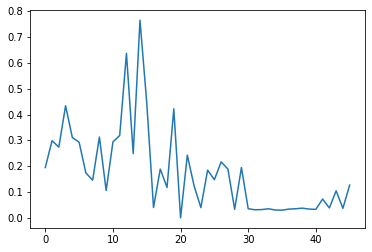

In [69]:
plt.plot(df['valence_list'][0])

In [83]:
#sample
#normalized_xaxis = [x/len(lotr_energy) for x in range(len(lotr_energy))]

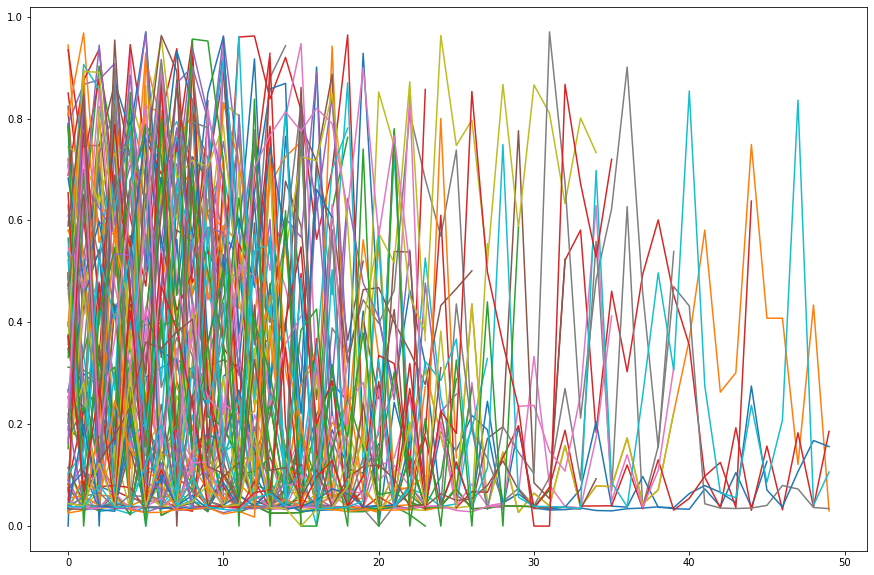

In [88]:
plt.figure(figsize=(15,10))
for i in range(0,100):
    plt.plot(df['valence_list'][i])

<function matplotlib.pyplot.show(close=None, block=None)>

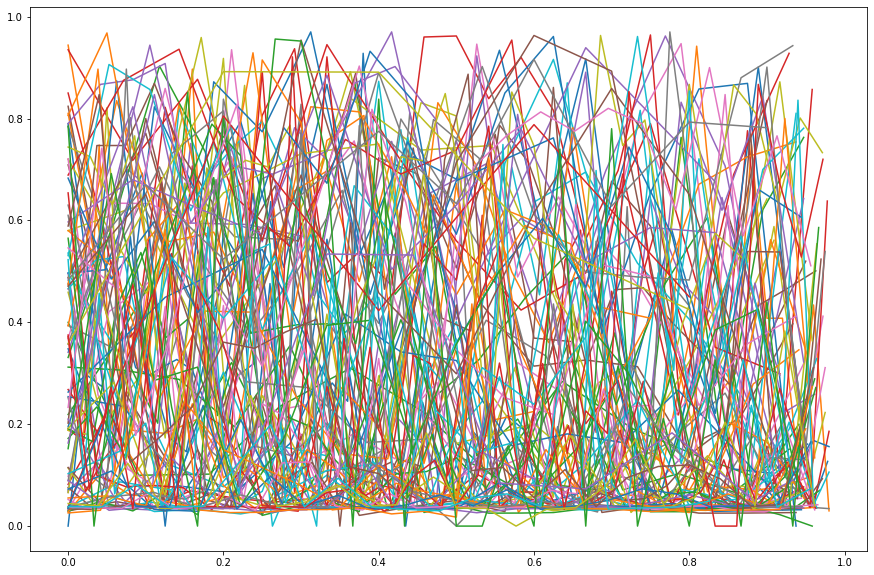

In [96]:
plt.figure(figsize=(15,10))
for i in range(0,100):
    x = [j/len(df['valence_list'][i]) for j in range(len(df['valence_list'][i]))]
    y = df['valence_list'][i]
    plt.plot(x,y)
plt.show

#### Scores normalisieren?

In [ ]:
def create_normalized_time_series(valence_scores):
    pass
    # return times series in Prozent 

Nur Achse beim Plotten normalisieren

#### Visualisierungen von Emotion Arcs, Filter nach Genres

### Schritt 3: Clusteranalyse

Im Paper verwendet: Principal Component Analysis | Hierarchical Clustering | SOM

### Ausblick: Mehr Detail am Beispiel von Cyanite